<a href="https://colab.research.google.com/github/bhattacharjee/silver-garbanzo/blob/main/ransomware_detection_adversarial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introuction

Brief outline of this notebook:

1. We start by importing some necessary modules
2. We load a prepared dataset containing encrypted and plaintext files
3. We train a neural network to detect to detect encrypted content
4. We explore the data to get a sense of how the neural network might have made it's decision.
5. We use this information to run an attack (we have already pre-processed the adversarial dataset)
6. We use the trained model to predict the labels on the adversarial dataset.
7. Finally we explore the data to see what went wrong.


## Import some modules and download the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import IPython

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


!git clone https://github.com/bhattacharjee/silver-garbanzo.git >/dev/null 2>&1
!cp -r silver-garbanzo/data/*.gz .
!ls

expanded.pyencrypted_v1.b32.csv.gz  plaintext.expanded.csv.gz  silver-garbanzo
expanded.pyencrypted_v1.csv.gz	    sample_data


In [2]:
df_plaintext = pd.read_csv('plaintext.expanded.csv.gz')
df_plaintext["encrypted"] = 0
df_plaintext = df_plaintext[df_plaintext["extension"] != ".webp"]

df_encrypted = pd.read_csv('expanded.pyencrypted_v1.csv.gz')
df_encrypted["encrypted"] = 1
df_encrypted[df_encrypted["extension"] != ".webp"]

df_encrypted_base32 = pd.read_csv('expanded.pyencrypted_v1.b32.csv.gz')
df_encrypted_base32["encrypted"] = 1
df_encrypted_base32[df_encrypted_base32["extension"] != ".webp"]

training_and_validation_data = pd.concat([df_plaintext, df_encrypted])

# Drop the file type, and scale the data
# Scaling is necessary for any machine learning, especially neural networks,
# which don't work without scaling.

training_and_validation_data.drop(\
                                columns=['filename', 'extension'], \
                                inplace=True)
df_encrypted_base32.drop(columns=['filename', 'extension'], inplace=True)

scaler = MinMaxScaler()
training_and_validation_data = scaler.fit_transform(training_and_validation_data)
train_columns = [c for c in df_encrypted_base32.columns if "encrypted" != c]

df_encrypted_base32 = scaler.transform(df_encrypted_base32)

# Split columsn into features and target labels
# X represents the features, and y the target labels
X, y = training_and_validation_data[:,:-1], training_and_validation_data[:,-1]

b32_X, b32_y = df_encrypted_base32[:,:-1], df_encrypted_base32[:,-1]


X_train, X_test, y_train, y_test= \
    train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val= \
    train_test_split(X_train, y_train, test_size=0.2)

 We now train a neural network to distinguish between encrypted and plaintext content. 

 For our dataset, we use a corpus of about 50,000 encrypted and 50,000 plaintext files.

 The encrypted files are encrypted with the AES algorithm.
 
 We build a fully connected neural network and train it. Off the bat, we get
 a good test accuracy.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 28        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 10        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 83
Trainable params: 83
Non-trainable para

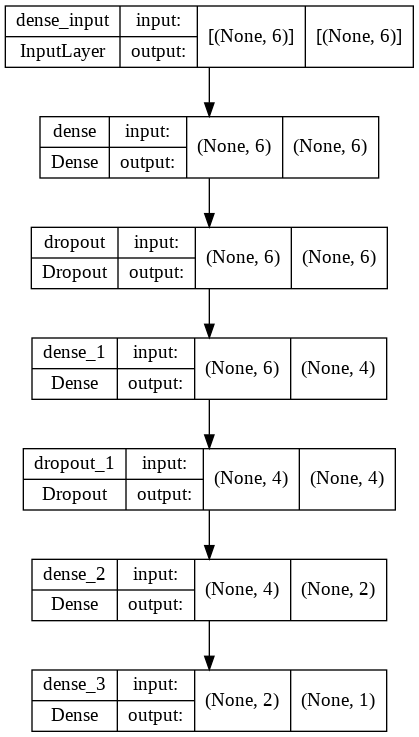

Epoch 1/3
5854/5854 [==============================] - 35s 5ms/step - loss: 0.4344 - accuracy: 0.8244 - val_loss: 0.2155 - val_accuracy: 0.9436
Epoch 2/3
5854/5854 [==============================] - 20s 3ms/step - loss: 0.2526 - accuracy: 0.9174 - val_loss: 0.1826 - val_accuracy: 0.9523
Epoch 3/3
5854/5854 [==============================] - 20s 3ms/step - loss: 0.2215 - accuracy: 0.9300 - val_loss: 0.1652 - val_accuracy: 0.9527


In [3]:
class Model:
    def create(X):
        model = tf.keras.Sequential(
            [
                layers.Dense(6, input_dim=X.shape[1], activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(4, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(2, activation='relu'),
                layers.Dense(1, activation='sigmoid')
            ]
        )
        model.compile(\
                      loss='binary_crossentropy', \
                      optimizer='adam', \
                      metrics=['accuracy'])
        Model.print_and_plot(model)
        return model
    
    def print_and_plot(model):
        print(model.summary())
        plot = tf.keras.utils.plot_model(
            model,
            show_shapes=True,
            expand_nested=True)
        IPython.display.display(plot)

model = Model.create(X_train)

history = model.fit(X_train, y_train,
            epochs=3,
            validation_data=(X_val, y_val),
            batch_size=16)


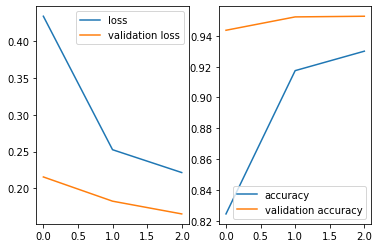

In [4]:
fig, ax = plt.subplots(1, 2)

plt.sca(ax[0])
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()


In [5]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_test, y_pred)

print(f"Test Accuracy    : {test_accuracy}")
print(f"Test F1          : {test_f1_score}")

Test Accuracy    : 0.9491890229840879
Test F1          : 0.960106222463637


# The attack

Now let's say the attacker has smarted up, and what he does is after encrypting the files, he uses base-32 encoding on the encrypted files.

We now test the accuracy of our trained model against the same set of 50,000 encrypted files. The only difference is that this time, the files have been base-32 encoded after encryption.

In [6]:
b32_y_pred = model.predict(b32_X)
b32_y_pred = b32_y_pred > 0.5

base32_accuracy = accuracy_score(b32_y, b32_y_pred)
base32_f1_score = f1_score(b32_y, b32_y_pred)

print(f"Base 32 Test Accuracy    : {base32_accuracy}")
print(f"Base 32 Test F1          : {base32_f1_score}")

Base 32 Test Accuracy    : 0.0
Base 32 Test F1          : 0.0


## Massive failure

It appears that our accuracy was 0.

So we look at what went wrong.

In [8]:
print(b32_y_pred)

[[False]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]


Aparently, everything was classified as plaintext


## Now we try to dig into why this happened

In general, the output of any good encryption algorithm looks like a random sequence of bytes. If the appearance of encrypted text is not random, then the encryption algorithm is not a very strong algorithm.

Our neural network tries to use this property of encryption to distinguish between encrypted and unencrypted content.

But how does it do that? It uses a few statistical measures.

A very common statistical measure is Shannon's Entropy, and is given by the following expression:

$\displaystyle \mathrm {H} (X)=-\sum _{i=1}^{n}{\mathrm {P} (x_{i})\log \mathrm {P} (x_{i})}$

Entropy measures the *randomness* of a given text. If the text has a lot of different characters, and each of those characters appears roughly the same number of times, then it would have a high entropy. By contrast, if the text has only a small number of characters, or if few of the characters dominate the frequency count, and other characters are less frequent, then the entropy will be low.

In general, encrypted text has a high entropy. But when encrypted text is converted to base-32, the encoding reduces the number of characters in the text, and that, in turn, reduces the entropy.

Besides entropy, our dataset also had a few other measures of randomness:
1. Chi-square metric
2. Monte-carlo simulation of $\pi$
3. Auto-correlation

We will now plot the entropy values in the files in the original plaintext, and the original (non-base32) encrypted text to show 